In [1]:
!which python

/bin/bash: /home/shiya/anaconda3/envs/music/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/shiya/anaconda3/envs/music/bin/python


In [2]:
import librosa
import librosa.display
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import os 
import random


import spectrogram
from spectrogram import generate_spec
from spectrogram import truncate_spec
from spectrogram import mask_spec

2022-07-06 10:09:32.452638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 10:09:32.824718: E tensorflow/stream_executor/cuda/cuda_blas.cc:3005] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-07-06 10:09:33.891778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shiya/anaconda3/envs/music/lib/
2022-07-06 10:09:33.892135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [3]:
import inspect
print(inspect.getsource(generate_spec))

def generate_spec(path, sr = None, full_path = False, noise = True, 
                    **kwargs):
    '''
    Generate spectrogram's numpy nd.array base on directory.
    The first dimension contains the frequency bins, whereas the second
    dimension represents the windows bin.

    The dtype of the numpy array is of complex64 type. The magniudes
    represent the magnitude of the frequency bins, and the angles represent
    the phase of corresponding frequency.

    Input: String, path to audio file.
    Output: 2 dimensions nd.array.
    '''
    rel_path = glob.glob('../data/**[!MACOSC]/*OrchideaSOL2020/', recursive=True)[0]
    if full_path == False:
        true_path = rel_path + path
    else:
        true_path = path
    file, sr = librosa.load(true_path, sr=sr)
    if noise == True:
        file = add_noise(file)
    y = librosa.stft(file, **kwargs)
    return np.abs(y)



In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-07-06 10:09:34.959270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 10:09:34.987958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 10:09:34.988300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
import librosa

# 1. Get the file path to an included audio example
filename = librosa.example('nutcracker')


# 2. Load the audio as a waveform `y`
#    Store the sampling rate as `sr`
y, sr = librosa.load(filename)
print(y)

# 3. Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)


[ 2.2716861e-06  5.3327208e-06 -7.2473290e-06 ...  1.1170751e-05
  1.2871884e-06  5.4120628e-06]
Estimated tempo: 107.67 beats per minute


In [6]:
y, sr = librosa.load(librosa.ex('trumpet'))
spec = librosa.feature.melspectrogram(y=y, sr=sr) 

In [7]:
y.shape

(117601,)

In [8]:
print(sr)

22050


<AxesSubplot:>

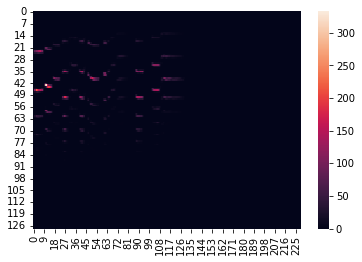

In [9]:
sns.heatmap(spec)

/home/shiya/anaconda3/envs/music/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


<AxesSubplot:>

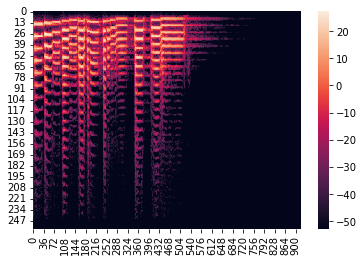

In [10]:
sns.heatmap(librosa.amplitude_to_db(librosa.stft(y, n_fft = 512)), cmap = 'rocket')

print(librosa.stft.__doc__)

In [11]:
hop_length = 4096
win_length = 1024
n_fft = 1024

In [12]:
%%time
spectrogram.generate_spec('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', hop_length = hop_length, 
                win_length = win_length, n_fft = n_fft).shape

CPU times: user 36 ms, sys: 44.5 ms, total: 80.5 ms
Wall time: 128 ms


(513, 202)

In [13]:
%%time 
sample_raw, _ =librosa.load('../data/_OrchideaSOL2020_release/OrchideaSOL2020/PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 1.53 s, sys: 50.7 ms, total: 1.58 s
Wall time: 1.02 s


In [14]:
print(scipy.stats.iqr(sample_raw))

0.00021132442270754836


In [15]:
test = np.array([2, 4, 6, 8, 10])
scipy.convolve(test,np.ones(5,dtype='float')/5, 'same')

/tmp/ipykernel_6831/1454046401.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  scipy.convolve(test,np.ones(5,dtype='float')/5, 'same')


array([2.4, 4. , 6. , 5.6, 4.8])

In [16]:
def rolling_mean(arr, win):
    return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')

In [17]:
def get_signal_range(arr):
    tmp = rolling_mean(arr, 100) < 0.001
    rolling_tmp = [all(tmp[x:x+500]) for x in range(len(tmp) - 500)]
    # plt.scatter(range(len(rolling_tmp)), rolling_tmp)
    for i in range(len(rolling_tmp)):
        if rolling_tmp[i] == True:
            return i

In [18]:
%%time
print(get_signal_range(sample_raw))

/tmp/ipykernel_6831/4247337007.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')


27590
CPU times: user 4.52 s, sys: 692 µs, total: 4.53 s
Wall time: 4.52 s


/tmp/ipykernel_6831/4247337007.py:2: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  return scipy.convolve(arr, np.ones(win, dtype = 'float')/win, 'same')


(0.0, 1000.0)

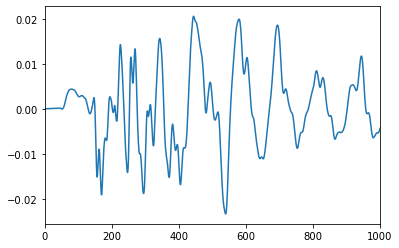

In [19]:
plt.plot(rolling_mean(sample_raw, 100))
plt.xlim(0, 1000)

(0.0, 1000.0)

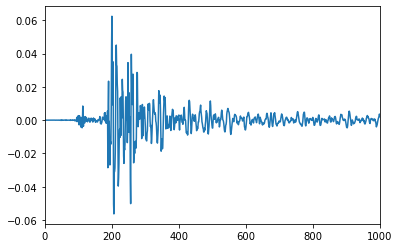

In [20]:
plt.plot(np.diff(sample_raw, 2))
plt.xlim(0, 1000)

5.545808e-07


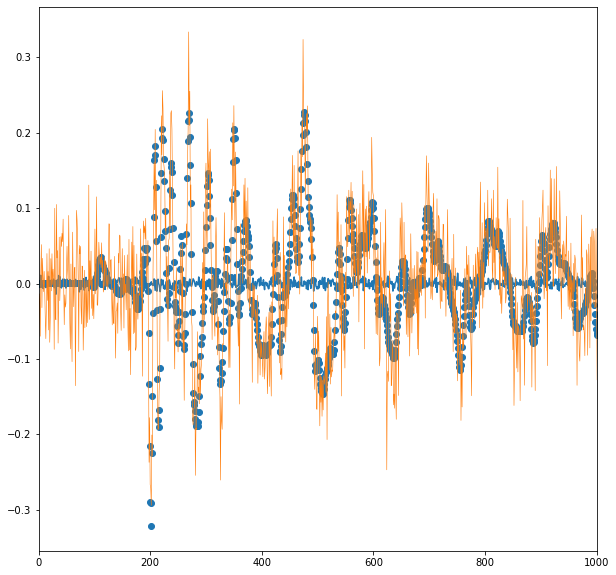

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(range(len(sample_raw)), sample_raw)
print(sample_raw.mean())
plt.xlim((0, 1000))
plt.plot(np.random.normal(0, sample_raw.std(), size = 1000))
plt.plot(sample_raw + np.random.normal(0, 0.05, size = sample_raw.shape), linewidth= 0.6, 
           linestyle = '-')

In [22]:
type(sample_raw)

numpy.ndarray

In [23]:
%%time
sample = spectrogram.generate_spec('PluckedStrings/Harp/pizzicato_bartok/Hp-pizz_bartok-G3-ff-N-N.wav', hop_length = hop_length, 
                win_length = win_length, n_fft = n_fft)

CPU times: user 42.6 ms, sys: 52.6 ms, total: 95.2 ms
Wall time: 156 ms


Text(0.5, 1.0, 'Log-frequency power spectrogram')

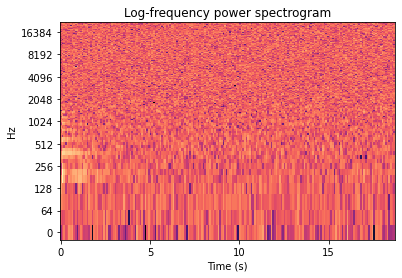

In [24]:
fig = plt.figure()
D = librosa.amplitude_to_db(sample,
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=44100, hop_length=hop_length,
                         x_axis='s')
plt.title('Log-frequency power spectrogram')

In [25]:
sample.shape

(513, 202)

In [26]:
tf.data.Dataset.from_tensor_slices(sample)

2022-07-06 10:09:44.850619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 10:09:44.851685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 10:09:44.852103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 10:09:44.852359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<TensorSliceDataset element_spec=TensorSpec(shape=(202,), dtype=tf.float64, name=None)>

In [27]:
librosa.stft(y, n_fft = 512)

array([[ 2.1919990e-03+0.0000000e+00j, -1.4984594e-03+0.0000000e+00j,
        -3.7925106e-03+0.0000000e+00j, ...,
         2.3942404e-08+0.0000000e+00j, -1.0389048e-07+0.0000000e+00j,
        -1.2857109e-06+0.0000000e+00j],
       [-5.7481867e-03-4.3230206e-03j,  5.6010368e-03-3.8339014e-04j,
        -4.0086496e-04+5.5423792e-04j, ...,
         3.1411400e-08-8.3640463e-09j, -5.0904543e-08-4.7256105e-08j,
         5.4454540e-07-1.1114313e-06j],
       [ 1.4769356e-02+2.3543192e-03j, -1.0303578e-02-1.2755980e-02j,
        -8.4517188e-03+1.0901684e-02j, ...,
         4.4940474e-08-2.8125244e-09j, -6.4107148e-08-7.2129964e-08j,
         7.4693628e-07+9.8385283e-07j],
       ...,
       [-7.2194997e-04+2.3245620e-05j,  3.5452374e-04-1.9947761e-06j,
         1.4692579e-06+1.2078042e-06j, ...,
        -2.5920308e-04+1.0048603e-04j,  2.7742214e-04-3.2669326e-04j,
        -1.3921515e-04+2.6892315e-04j],
       [ 7.3494151e-04-1.2279861e-05j, -6.8163592e-07-3.6527147e-04j,
        -7.4732316e-06

In [28]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')
meta_df.head()

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0
2,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,f,3.0,0.0,S,Sordina,NaN,True,1
3,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,p,1.0,0.0,S,Sordina,NaN,True,2
4,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#2,46.0,f,3.0,0.0,S,Sordina,NaN,True,1


In [29]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13265 entries, 0 to 13264
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Path                         13265 non-null  object 
 1   Family (abbr.)               13265 non-null  object 
 2   Family (in full)             13265 non-null  object 
 3   Instrument (abbr.)           13265 non-null  object 
 4   Instrument (in full)         13265 non-null  object 
 5   Technique (abbr.)            13265 non-null  object 
 6   Technique (in full)          13265 non-null  object 
 7   Pitch                        13265 non-null  object 
 8   Pitch ID (if applicable)     13162 non-null  float64
 9   Dynamics                     13265 non-null  object 
 10  Dynamics ID (if applicable)  12646 non-null  float64
 11  Instance ID                  13262 non-null  float64
 12  Mute (abbr.)                 13265 non-null  object 
 13  Mute (in full)  

In [30]:
meta_df.describe()

,Pitch ID (if applicable),Dynamics ID (if applicable),Instance ID,String ID (if applicable),Fold
count,13162.000000,12646.000000,13262.000000,7516.000000,13265.000000
mean,63.842653,2.073857,0.848138,2.360298,2.000000
std,16.512067,1.329919,1.177874,1.196041,1.414267
min,20.000000,0.000000,0.000000,1.000000,0.000000
25%,52.000000,2.000000,0.000000,1.000000,1.000000
50%,64.000000,2.000000,0.000000,2.000000,2.000000
75%,76.000000,3.000000,2.000000,3.000000,3.000000
max,109.000000,4.000000,12.000000,6.000000,4.000000


In [31]:
meta_df.isnull().sum()

Path                              0
Family (abbr.)                    0
Family (in full)                  0
Instrument (abbr.)                0
Instrument (in full)              0
Technique (abbr.)                 0
Technique (in full)               0
Pitch                             0
Pitch ID (if applicable)        103
Dynamics                          0
Dynamics ID (if applicable)     619
Instance ID                       3
Mute (abbr.)                      0
Mute (in full)                    0
String ID (if applicable)      5749
Needed digital retuning           0
Fold                              0
dtype: int64

In [32]:
meta_df['Instrument (in full)'].value_counts()

Violin            1987
Viola             1952
Contrabass        1636
Cello             1593
Accordion          872
Trombone           670
Trumpet in C       590
French Horn        589
Flute              529
Harp               507
Bass Tuba          500
Clarinet in Bb     406
Alto Saxophone     377
Bassoon            358
Guitar             353
Oboe               346
Name: Instrument (in full), dtype: int64

In [33]:
len(meta_df['Instrument (in full)'].unique())

16

We don'really care about the pitchID, Dynamics Id and String ID.

## First baseline model is to predict the instrument present in the audio file.


In [34]:
train_df, test_df = train_test_split(meta_df, train_size = 0.7, random_state = 42)

In [35]:
print('The number of rows for the training data is ', train_df.shape[0])
print('The number of rows for the test data is ', test_df.shape[0])

The number of rows for the training data is  9285
The number of rows for the test data is  3980


In [36]:
spec_shape = sample.shape
spec_shape

(513, 202)

In [37]:
meta_df

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0
2,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,f,3.0,0.0,S,Sordina,NaN,True,1
3,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34.0,p,1.0,0.0,S,Sordina,NaN,True,2
4,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#2,46.0,f,3.0,0.0,S,Sordina,NaN,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13260,Winds/Sax_Alto/slap_pitched/ASax-slap-G4-f-N-N...,Winds,Woodwinds,ASax,Alto Saxophone,slap,slap_pitched,G4,67.0,f,3.0,0.0,N,None,NaN,False,1
13261,Winds/Sax_Alto/slap_pitched/ASax-slap-G4-mf-N-...,Winds,Woodwinds,ASax,Alto Saxophone,slap,slap_pitched,G4,67.0,mf,2.0,0.0,N,None,NaN,False,4
13262,Winds/Sax_Alto/slap_unpitched/ASax-slap_unp-C#...,Winds,Woodwinds,ASax,Alto Saxophone,slap_unp,slap_unpitched,C#3,49.0,p,1.0,0.0,N,None,NaN,False,2
13263,Winds/Sax_Alto/slap_unpitched/ASax-slap_unp-C#...,Winds,Woodwinds,ASax,Alto Saxophone,slap_unp,slap_unpitched,C#4,61.0,p,1.0,0.0,N,None,NaN,False,0


In [38]:
model = models.Sequential()
model.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1), dtype = tf.float64))
model.add(layers.Conv2D(30, (200, 20), strides=(10, 10), activation='relu'))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model.add(layers.MaxPool2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'sigmoid'))
model.build()

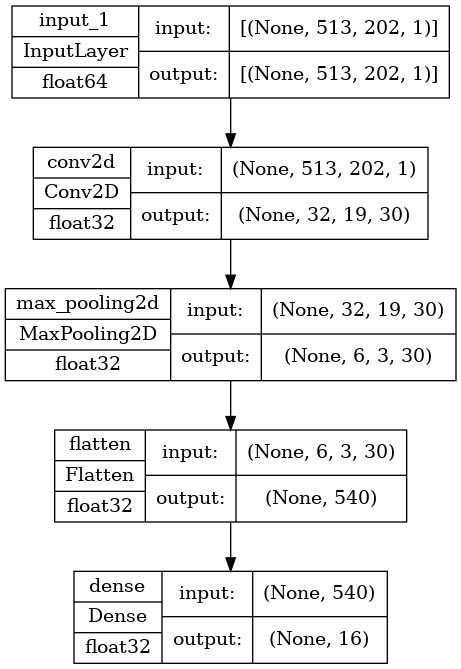

In [39]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype= True)

In [40]:
instrument_df = meta_df[['Path', 'Instrument (in full)']]
dummy_df = pd.get_dummies(instrument_df, columns = ['Instrument (in full)'])
train_df, test_df = train_test_split(dummy_df, train_size = 0.75)
train_df.head(2)

,Path,Instrument (in full)_Accordion,Instrument (in full)_Alto Saxophone,Instrument (in full)_Bass Tuba,Instrument (in full)_Bassoon,Instrument (in full)_Cello,Instrument (in full)_Clarinet in Bb,Instrument (in full)_Contrabass,Instrument (in full)_Flute,Instrument (in full)_French Horn,Instrument (in full)_Guitar,Instrument (in full)_Harp,Instrument (in full)_Oboe,Instrument (in full)_Trombone,Instrument (in full)_Trumpet in C,Instrument (in full)_Viola,Instrument (in full)_Violin
5469,Strings/Contrabass/sul_tasto_tremolo/Cb-tasto_...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6072,Strings/Viola/artificial_harmonic/Va-art_harm-...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
random.random()

0.5412412058403092

In [42]:
def gen():
    df = train_df.copy()
    while True: 
        tmp_df = df.sample(1)
        path = tmp_df['Path'].values[0]
        if random.random() < 0.3:
            noise_bool = True
        else:
            noise_bool = False
        spec = generate_spec(path, hop_length = hop_length, win_length = win_length,
                                n_fft = n_fft, noise= noise_bool)
        spec = truncate_spec(spec, spec_shape[1])
        if random.random() < 0.3:
            spec = mask_spec(spec) 
        spec = np.expand_dims(spec, -1)
        yield spec, np.reshape(tmp_df[list(set(df.columns) - set(['Path']))].values, (16,))
    
def gen_eval():
    df = test_df.copy()
    while True:
        tmp_df = df.sample(1)
        path = tmp_df['Path'].values[0]
        if random.random() < 0.3:
            noise_bool = True
        else:
            noise_bool = False
        spec = generate_spec(path, hop_length = hop_length, win_length = win_length, n_fft = n_fft)
        spec = truncate_spec(spec, spec_shape[1])
        if random.random() < 0.3:
            spec = mask_spec(spec) 
        spec = np.expand_dims(spec, -1)
        yield spec, np.reshape(tmp_df[list(set(df.columns) - set(['Path']))].values, (16,))

In [61]:
def get_eval_df(df):
    tmp = df.copy()
    tmp['spec'] = tmp['Path'].apply(generate_spec)
    tmp.drop(columns=['Path'], inplace = True)
    return tmp

In [43]:
# def npy_gen():
    

In [44]:
sample = next(gen())
print(sample[0].shape)
sample[1].shape

(513, 202, 1)


(16,)

In [ ]:
librosa.display.specshow(sample)

In [45]:
BATCH_SIZE = 100

train_generator = (tf.data.Dataset.from_generator(gen, output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)
eval_generator = (tf.data.Dataset.from_generator(gen_eval, output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print(model.metrics)

[]


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 19, 30)        120030    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 3, 30)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 16)                8656      
                                                                 
Total params: 128,686
Trainable params: 128,686
Non-trainable params: 0
_________________________________________________________________


In [48]:
len(train_df)//BATCH_SIZE

99

In [49]:
from datetime import datetime
datetime.now().strftime('%Y%m%d_%H%M%S')


'20220706_100948'

In [62]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = model.fit(train_generator, epochs = 6, verbose=1, steps_per_epoch= 10, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/6
10/10 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.4790 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_01_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_01_model/assets


10/10 [==============================] - 526s 53s/step - loss: 0.1695 - accuracy: 0.4790
Epoch 2/6
10/10 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.5050 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_02_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_02_model/assets


10/10 [==============================] - 991s 105s/step - loss: 0.1580 - accuracy: 0.5050 - val_loss: 0.1967 - val_accuracy: 0.2300
Epoch 3/6
10/10 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.4910 

INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_03_model/assets


INFO:tensorflow:Assets written to: ../models/baseline_checkpoint/20220706_160108_03_model/assets


10/10 [==============================] - 527s 53s/step - loss: 0.1590 - accuracy: 0.4910
Epoch 4/6
 3/10 [========>.....................] - ETA: 6:08 - loss: 0.1579 - accuracy: 0.4833

In [52]:
# model.save('../models/baseline/')

In [53]:
# model = tf.keras.models.load_model('../models/baseline_checkpoint/20220705_135043_02_model/')

In [54]:
# model.save_weights('../models/baseline_checkpoint/20220704_153658_model/')

In [55]:
model.evaluate(eval_generator, steps = len(test_df)//25)

 39/132 [=======>......................] - ETA: 1:06:51 - loss: 0.2258 - accuracy: 0.1038

KeyboardInterrupt: 

In [ ]:
model(np.reshape(random_train, (1, 1025, 807, 1)), training= False)

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0.25098786, 0.28979725, 0.19388774, 0.3408277 , 0.29772896,
        0.41419387, 0.20505759, 0.24066192, 0.49796218, 0.2604622 ,
        0.32297462, 0.41928884, 0.14825433, 0.24044338, 0.35180917,
        0.27159938]], dtype=float32)>